In [14]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
n_scenarios = 10000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma = 0.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [16]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)], axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.96,1.75
std,0.00,0.97,0.59
p_breach,NaN,0.04,0.01
e_short,NaN,0.12,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [17]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75)], axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.96,1.75,1.94
std,0.00,0.97,0.59,0.98
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.12,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [19]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=5)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75)
          ], axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5
mean,1.3433,1.9590,1.7506,1.9350,1.6171,1.9455
std,0.0000,0.9722,0.5906,0.9779,0.4290,0.9804
p_breach,NaN,0.0351,0.0085,NaN,NaN,0.0002
e_short,NaN,0.1240,0.0745,NaN,NaN,0.0003
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


## Risk Budgetting with Drawdown Constraints

- Can't use zero coupon bonds but its price return might continue to drop
- Use Cash instead

In [20]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75),
          ], axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,MaxDD25
mean,1.3433,1.9590,1.7506,1.9350,1.6171,1.9455,1.6217
std,0.0000,0.9722,0.5906,0.9779,0.4290,0.9804,0.5359
p_breach,NaN,0.0351,0.0085,NaN,NaN,0.0002,NaN
e_short,NaN,0.1240,0.0745,NaN,NaN,0.0003,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.200663
1   -0.136195
2   -0.204391
3   -0.165513
4   -0.145347
Name: Max Drawdown, dtype: float64

In [22]:
max_dd = erk.summary_stats(rets_maxdd25)["Max Drawdown"]

In [23]:
max_dd.min()

-0.23852310753033107

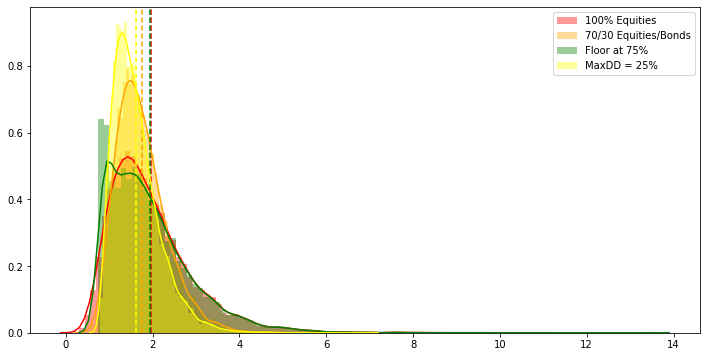

In [26]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

# Plot
plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--",color="red")

sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--",color="orange")

sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--",color="green")

sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--",color="yellow")

plt.legend()

# Drawdown constraint with Historical Data

<AxesSubplot:>

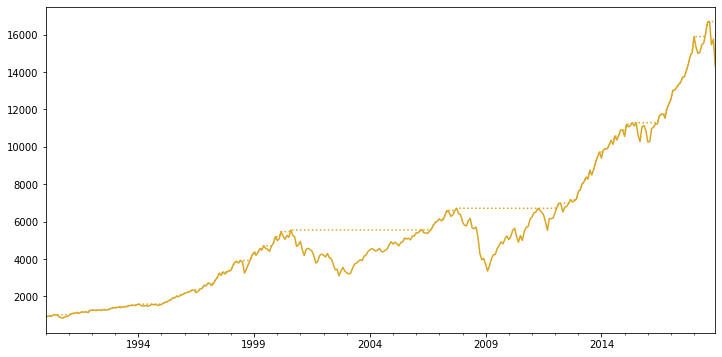

In [37]:
rets_tmi = erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

<AxesSubplot:>

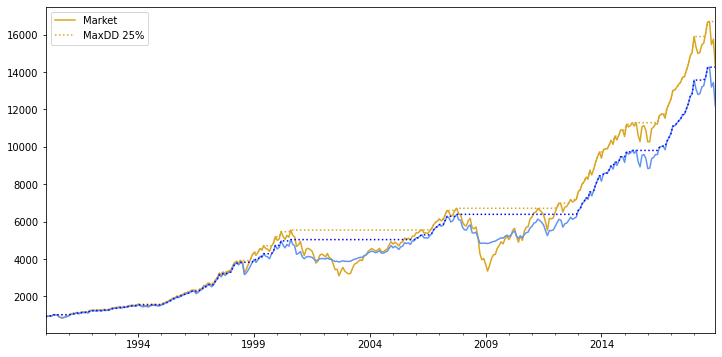

In [41]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0]) #rets_maxdd25 is DataFrame; rets_maxdd25[0] is a Series

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="blue",ls=":")

In [43]:
rets_maxdd25[0]

1990-01    -0.0723549
1990-02     0.0160159
1990-03     0.0246959
1990-04    -0.0272561
1990-05     0.0905453
              ...    
2018-08     0.0369511
2018-09    0.00210787
2018-10    -0.0742918
2018-11     0.0181604
2018-12    -0.0929108
Freq: M, Name: 0, Length: 348, dtype: object

In [44]:
rets_maxdd25

,0
1990-01,-0.0723549
1990-02,0.0160159
1990-03,0.0246959
1990-04,-0.0272561
1990-05,0.0905453
...,...
2018-08,0.0369511
2018-09,0.00210787
2018-10,-0.0742918
2018-11,0.0181604


In [45]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
